# Time Series Forecasting

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
# from datasets import Dataset, DatasetDict
from tabpfn_time_series import TimeSeriesDataFrame
# from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X
# from tabpfn_time_series.plot import plot_actual_ts
from tabpfn_time_series import FeatureTransformer

from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode
# from tabpfn_time_series.plot import plot_pred_and_actual_ts
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [62]:
def get_date():
    
    """
    Returns today's date in the format year-month-day
    """
    
    return datetime.today().strftime('%Y-%m-%d')

def get_stock_data(stock_name, period='2y', interval='1h'):
    
    """
    Uses the yahoo finance API to extract historical stock price data for a given stock
    and a given starting date
    """
    
    data = yf.Ticker(stock_name).history(period=period, interval=interval)
    data.reset_index(inplace=True)
    data["Datetime"] = data["Datetime"].apply(lambda x: str(x)[:-6])
    data["Datetime"] = pd.to_datetime(data["Datetime"])
    data['timestamp'] = data['Datetime'].dt.to_pydatetime()
    data['target'] = data['Close'].pct_change()*10000
    data = data.dropna().reset_index(drop=True)
    return data

## TabPFN

In [65]:
# Add features
from tabpfn_time_series.features import (
    RunningIndexFeature,
    CalendarFeature,
    AutoSeasonalFeature,
)

selected_features = [
    RunningIndexFeature(),
    CalendarFeature(),
    AutoSeasonalFeature(),
]

feature_transformer = FeatureTransformer(selected_features)

In [66]:
# 1) Download daily prices and compute log-returns
ticker = "AAPL"
df = yf.download(ticker, period="5y", interval="1d")
df = df[['Close']].rename(columns={'Close': 'price'})
df['ret'] = np.log(df['price']).diff()
df = df.dropna()

# # 2) Basic calendar features (no leakage)
# df['dayofweek'] = df.index.dayofweek
# df['month'] = df.index.month

# 3) Lag features (predict next-day return using past info)
for L in [1, 2, 5, 10, 20, 60, 120, 250]:
    df[f'ret_lag_{L}'] = df['ret'].shift(L)

# 4) Drop rows with NaNs introduced by lags
df = df.dropna()

# 5) Target: next-day return
df['ret_next'] = df['ret'].shift(-1)
df = df.dropna()

[*********************100%***********************]  1 of 1 completed


In [67]:

# A single series example; for multiple tickers, stack with item_id and timestamp
df_single = df.copy()
df_single.columns = df.columns.get_level_values(0)
df_single['item_id'] = ticker
df_single['timestamp'] = df_single.index

# Features vs target
features = [c for c in df_single.columns if c.startswith('ret_lag_')]
target = 'ret_next'

X = df_single[['item_id', 'timestamp'] + features]
y = df_single[target]

# Chronological split (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

In [68]:
# Construct TimeSeriesDataFrame expected by TabPFN-TS
train_tsd = X_train.copy()
train_tsd['target'] = y_train.values
train_tsd = TimeSeriesDataFrame(train_tsd.set_index(['item_id', 'timestamp']))

test_tsd = X_test.copy()
test_tsd['target'] = np.nan  # keep for evaluation alignment
test_tsd = TimeSeriesDataFrame(test_tsd.set_index(['item_id', 'timestamp']))

train_tsd, test_tsd = feature_transformer.transform(train_tsd, test_tsd)


In [69]:
# Initialize predictor (zero/low-shot; fast, no tuning)
predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)

# Predict on test horizon one-step ahead
# For one-step rolling forecasts, iterate; here we use batched next-step for simplicity
pred_df = predictor.predict(train_tsd, test_tsd)

# pred_df returns predicted values aligned to item_id/timestamp
pred_df = pred_df.reset_index().rename(columns={'mean': 'pred'})  # if probabilistic=True, 'mean' exists

Found existing access token, reusing it for authentication.

Processing: 100%|██████████| [00:05<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:10<00:00, 10.35s/it]


MAE: 0.013289 | RMSE: 0.021277


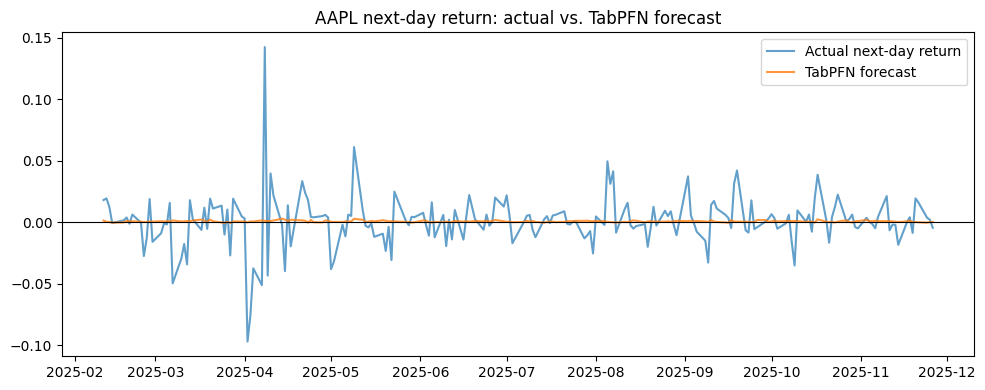

In [70]:
# Align predictions with true next-day returns
# eval_df = test_tsd.reset_index()[['timestamp', 'target']].merge(pred_df[['timestamp', 'target']], on='timestamp', how='inner').sort_values('timestamp')
# eval_df.columns = ['timestamp', 'target', 'pred']

eval_df = pred_df[['timestamp', 'target']].rename(columns = {'target': 'pred'})
eval_df.insert(1, 'target', y_test.values)
mae = np.mean(np.abs(eval_df['target'] - eval_df['pred']))
rmse = np.sqrt(np.mean((eval_df['target'] - eval_df['pred'])**2))
print(f"MAE: {mae:.6f} | RMSE: {rmse:.6f}")

plt.figure(figsize=(10,4))
plt.plot(eval_df['timestamp'], eval_df['target'], label='Actual next-day return', alpha=0.7)
plt.plot(eval_df['timestamp'], eval_df['pred'], label='TabPFN forecast', alpha=0.8)
plt.axhline(0, color='k', linewidth=0.8)
plt.legend()
plt.title(f'{ticker} next-day return: actual vs. TabPFN forecast')
plt.tight_layout()
plt.show()

In [71]:
eval_df['pos'] = eval_df['pred'].apply(lambda x: 1 if x>0 else (-1 if x <0 else 0))
eval_df['cumu_ret_act'] = (eval_df['target'].apply(lambda x: 1 if x>0 else (-1 if x <0 else 0)) * abs(eval_df['target']).mean()+1).cumprod() -1
eval_df['cumu_ret_pred'] = (eval_df['pos'] * eval_df['target']+1).cumprod() -1


<Axes: xlabel='timestamp'>

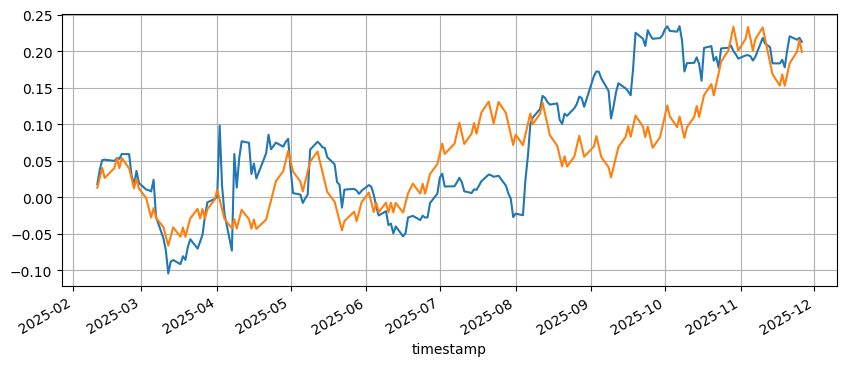

In [74]:
eval_df.set_index('timestamp')['cumu_ret_pred'].plot(figsize = (10, 4), grid=True)
eval_df.set_index('timestamp')['cumu_ret_act'].plot(figsize = (10, 4), grid=True)

In [75]:
eval_df.tail()

,timestamp,target,pred,pos,cumu_ret_act,cumu_ret_pred
196,2025-11-20,0.019490,0.000290,1,0.168100,0.201061
197,2025-11-21,0.016186,0.000071,1,0.183624,0.220501
198,2025-11-24,0.003798,-0.000298,-1,0.199354,0.215865
199,2025-11-25,0.002092,0.000180,1,0.215293,0.218409
200,2025-11-26,-0.004423,0.000314,1,0.199142,0.213019


In [78]:
eval_dfs = []
eval_dfs.append(eval_df)

## Hyothesis testing
H0: the excess return is smaller or equal to 0.

In [77]:
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'META', 'AMZN', 'TSLA', 'JPM', 'MS', 'UNH', 'PFE', \
    'XOM', 'CVX', 'PG', 'KO', 'CAT', 'UNP', 'NEE', 'DUK', 'LIN', 'NEM', \
    'NVDA', 'CSCO', 'NFLX', 'DIS', 'HD', 'MCD', 'BAC', 'WFC', 'JNJ', 'LLY', \
    'COP', 'SLB', 'PEP', 'WMT', 'GE', 'MMM', 'SO', 'AEP', 'SHW', 'FCX',\
    'AVGO', 'INTC', 'CHTR', 'TMUS', 'NKE', 'SBUX', 'AXP', 'BLK', 'MRK', 'ABBV',\
    'MPC', 'PSX', 'KMB', 'K', 'HON', 'LMT', 'D', 'EXC', 'DD', 'ALB',\
    'QCOM', 'ORCL', 'WBD', 'EA', 'LOW', 'BKNG', 'C', 'SCHW', 'BMY', 'GILD', \
    'EOG', 'HAL', 'KHC', 'ADM', 'RTX', 'DE', 'ETR', 'XEL', 'NUE', 'PPG',\
    'AMAT', 'ADBE', 'ROKU', 'TTWO', 'TGT', 'MAR', 'PRU', 'GS', 'AMGN', 'MRNA', \
    'COP', 'OXY', 'CL', 'TSN', 'FDX', 'ITW', 'SRE', 'PPL', 'STLD', 'MOS',\
    'USB', 'PYPL', 'HUM', 'CME', 'REGN', 'VLO', 'MDLZ', 'CAT', 'NOW', 'INTU', \
    'VZ', 'KR', 'CMG', 'CI', 'PH', 'BKR', 'NOC', 'IP', 'MLM', 'SNAP',\
    'ADI', 'KLAC', 'D', 'LYV', 'TJX', 'BBWI', 'PNC', 'ICE', 'DXCM', 'EW', \
    'APA', 'DVN', 'EL', 'BG', 'CMI', 'ROK', 'NI', 'ATO', 'AVY', 'BALL',\
    'MU', 'T', 'PINS', 'DLTR', 'EXPE', 'BAX', 'JCI', 'DOV', 'PEG', 'PKG', 'CF',\
    'STX', 'CDNS', 'WMG', 'LVS', 'ALL', 'AON', 'ZBH', 'EMN', 'ISRG', 'FOXA', 'YUM' \
    ]

# Add features
from tabpfn_time_series.features import (
    RunningIndexFeature,
    CalendarFeature,
    AutoSeasonalFeature,
)

selected_features = [
    RunningIndexFeature(),
    CalendarFeature(),
    AutoSeasonalFeature(),
]

feature_transformer = FeatureTransformer(selected_features)

In [79]:
# eval_dfs = []
for ticker in tickers[1:]:    
    df = yf.download(ticker, period="5y", interval="1d")
    df = df[['Close']].rename(columns={'Close': 'price'})
    df['ret'] = np.log(df['price']).diff()
    df = df.dropna()

    for L in [1, 2, 5, 10, 20, 60, 120, 250]:
        df[f'ret_lag_{L}'] = df['ret'].shift(L)

    df = df.dropna()
    df['ret_next'] = df['ret'].shift(-1)
    df = df.dropna()

    df_single = df.copy()
    df_single.columns = df.columns.get_level_values(0)
    df_single['item_id'] = ticker
    df_single['timestamp'] = df_single.index

    # Features vs target
    features = [c for c in df_single.columns if c.startswith('ret_lag_')]
    target = 'ret_next'

    X = df_single[['item_id', 'timestamp'] + features]
    y = df_single[target]

    # Chronological split (no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False
    )

    # Construct TimeSeriesDataFrame expected by TabPFN-TS
    train_tsd = X_train.copy()
    train_tsd['target'] = y_train.values
    train_tsd = TimeSeriesDataFrame(train_tsd.set_index(['item_id', 'timestamp']))

    test_tsd = X_test.copy()
    test_tsd['target'] = np.nan  # keep for evaluation alignment
    test_tsd = TimeSeriesDataFrame(test_tsd.set_index(['item_id', 'timestamp']))

    train_tsd, test_tsd = feature_transformer.transform(train_tsd, test_tsd)

    # Construct TimeSeriesDataFrame expected by TabPFN-TS
    train_tsd = X_train.copy()
    train_tsd['target'] = y_train.values
    train_tsd = TimeSeriesDataFrame(train_tsd.set_index(['item_id', 'timestamp']))

    test_tsd = X_test.copy()
    test_tsd['target'] = np.nan  # keep for evaluation alignment
    test_tsd = TimeSeriesDataFrame(test_tsd.set_index(['item_id', 'timestamp']))

    train_tsd, test_tsd = feature_transformer.transform(train_tsd, test_tsd)

    # Initialize predictor (zero/low-shot; fast, no tuning)
    predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)

    # Predict on test horizon one-step ahead
    # For one-step rolling forecasts, iterate; here we use batched next-step for simplicity
    pred_df = predictor.predict(train_tsd, test_tsd)

    # pred_df returns predicted values aligned to item_id/timestamp
    pred_df = pred_df.reset_index().rename(columns={'mean': 'pred'})  # if probabilistic=True, 'mean' exists

    eval_df = pred_df[['timestamp', 'target']].rename(columns = {'target': 'pred'})
    eval_df.insert(1, 'target', y_test.values)

    eval_df['pos'] = eval_df['pred'].apply(lambda x: 1 if x>0 else (-1 if x <0 else 0))
    eval_df['cumu_ret_act'] = (eval_df['target'].apply(lambda x: 1 if x>0 else (-1 if x <0 else 0)) * abs(eval_df['target']).mean()+1).cumprod() -1
    eval_df['cumu_ret_pred'] = (eval_df['pos'] * eval_df['target']+1).cumprod() -1

    eval_dfs.append(eval_df)

    print(ticker)

[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:05<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:10<00:00, 10.50s/it]
[*********************100%***********************]  1 of 1 completed


MSFT


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.55s/it]
[*********************100%***********************]  1 of 1 completed


GOOGL


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]
[*********************100%***********************]  1 of 1 completed


META


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.16s/it]
[*********************100%***********************]  1 of 1 completed


AMZN


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


TSLA


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.44s/it]
[*********************100%***********************]  1 of 1 completed


JPM


Processing:   0%|          | [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]
[*********************100%***********************]  1 of 1 completed


MS


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.48s/it]


UNH


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


PFE


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


XOM


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


CVX


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]


PG


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]


KO


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]
[*********************100%***********************]  1 of 1 completed


CAT


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.09s/it]


UNP


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]
[*********************100%***********************]  1 of 1 completed


NEE


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


DUK


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


LIN


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]
[*********************100%***********************]  1 of 1 completed


NEM


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]
[*********************100%***********************]  1 of 1 completed


NVDA


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]
[*********************100%***********************]  1 of 1 completed


CSCO


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.89s/it]


NFLX


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]
[*********************100%***********************]  1 of 1 completed

DIS



Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


HD


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


MCD


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  3.00s/it]


BAC


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


WFC


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


JNJ


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


LLY


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


COP


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


SLB


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


PEP


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


WMT


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


GE


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


MMM


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


SO


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


AEP


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.03s/it]


SHW


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.73s/it]
[*********************100%***********************]  1 of 1 completed


FCX


Processing:   0%|          | [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


AVGO


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]
[*********************100%***********************]  1 of 1 completed


INTC


Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]
[*********************100%***********************]  1 of 1 completed


CHTR


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]
[*********************100%***********************]  1 of 1 completed


TMUS


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]
[*********************100%***********************]  1 of 1 completed


NKE


Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]


SBUX


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]
[*********************100%***********************]  1 of 1 completed

AXP



Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


BLK


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]
[*********************100%***********************]  1 of 1 completed


MRK


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]
[*********************100%***********************]  1 of 1 completed


ABBV


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


MPC


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


PSX


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:02<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]


KMB


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]


K


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


HON


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


LMT


[*********************100%***********************]  1 of 1 completed
Processing:   0%|          | [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]


D


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.87s/it]


EXC


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


DD


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:04<00:00,  4.75s/it]


ALB


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.51s/it]


QCOM


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.58s/it]


ORCL


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:08<00:00,  8.33s/it]


WBD


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


EA


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


LOW


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.91s/it]


BKNG


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.46s/it]


C


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:07<00:00,  7.25s/it]


SCHW


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


BMY


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:07<00:00,  7.14s/it]


GILD


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.29s/it]


EOG


[*********************100%***********************]  1 of 1 completed
Processing:   0%|          | [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.82s/it]
[*********************100%***********************]  1 of 1 completed


HAL


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.18s/it]


KHC


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.08s/it]


ADM


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.99s/it]


RTX


[*********************100%***********************]  1 of 1 completed
Processing:   0%|          | [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.01s/it]


DE


[*********************100%***********************]  1 of 1 completed
Processing:   0%|          | [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.84s/it]


ETR


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.92s/it]


XEL


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.57s/it]


NUE


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]


PPG


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.01s/it]


AMAT


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]
[*********************100%***********************]  1 of 1 completed


ADBE


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.64s/it]


ROKU


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


TTWO


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:04<00:00,  4.48s/it]


TGT


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]
[*********************100%***********************]  1 of 1 completed


MAR


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


PRU


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
[*********************100%***********************]  1 of 1 completed


GS


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


AMGN


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.60s/it]


MRNA


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]


COP


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


OXY


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


CL


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


TSN


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:13<00:00, 13.35s/it]


FDX


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.22s/it]
[*********************100%***********************]  1 of 1 completed


ITW


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:07<00:00,  7.07s/it]


SRE


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]
[*********************100%***********************]  1 of 1 completed


PPL


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


STLD


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


MOS


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.11s/it]
[*********************100%***********************]  1 of 1 completed


USB


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


PYPL


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]
[*********************100%***********************]  1 of 1 completed


HUM


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.78s/it]


CME


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


REGN


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


VLO


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


MDLZ


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]
[*********************100%***********************]  1 of 1 completed


CAT


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]
[*********************100%***********************]  1 of 1 completed


NOW


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.31s/it]


INTU


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


VZ


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]
[*********************100%***********************]  1 of 1 completed


KR


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


CMG


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.76s/it]
[*********************100%***********************]  1 of 1 completed


CI


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.94s/it]
[*********************100%***********************]  1 of 1 completed


PH


Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


BKR


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.86s/it]


NOC


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.82s/it]
[*********************100%***********************]  1 of 1 completed


IP


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it]
[*********************100%***********************]  1 of 1 completed


MLM


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]
[*********************100%***********************]  1 of 1 completed


SNAP


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


ADI


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]
[*********************100%***********************]  1 of 1 completed


KLAC


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]
[*********************100%***********************]  1 of 1 completed


D


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]


LYV


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


TJX


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


BBWI


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]
[*********************100%***********************]  1 of 1 completed


PNC


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.28s/it]
[*********************100%***********************]  1 of 1 completed


ICE


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]
[*********************100%***********************]  1 of 1 completed


DXCM


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]


EW


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]


APA


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it]
[*********************100%***********************]  1 of 1 completed


DVN


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.49s/it]


EL


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


BG


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


CMI


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


ROK


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


NI


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


ATO


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.00s/it]


AVY


[*********************100%***********************]  1 of 1 completed
Processing:   0%|          | [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:13<00:00, 13.92s/it]


BALL


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.50s/it]


MU


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.05s/it]
[*********************100%***********************]  1 of 1 completed


T


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.01s/it]


PINS


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.71s/it]
[*********************100%***********************]  1 of 1 completed


DLTR


Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.43s/it]


EXPE


[*********************100%***********************]  1 of 1 completed
Processing:   0%|          | [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.51s/it]


BAX


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.04s/it]


JCI


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


DOV


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


PEG


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]
[*********************100%***********************]  1 of 1 completed

PKG



Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


CF


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


STX


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


CDNS


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.96s/it]
[*********************100%***********************]  1 of 1 completed


WMG


Processing: 100%|██████████| [00:00<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


LVS


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


ALL


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:04<00:00,  4.35s/it]


AON


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:08<00:00,  8.65s/it]


ZBH


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.27s/it]


EMN


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.41s/it]


ISRG


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:05<00:00,  5.39s/it]


FOXA


[*********************100%***********************]  1 of 1 completed
Processing: 100%|██████████| [00:01<00:00]/1 [00:00<?, ?it/s]
Predicting time series: 100%|██████████| 1/1 [00:06<00:00,  6.56s/it]

YUM


In [96]:
ret = []
for i in range(len(eval_dfs)):
    df = eval_dfs[i].copy()
    df['pos'] = (df['pred']*1000).round()
    df['cumu_ret_pred'] = (df['pos'] * df['target'] + 1).cumprod() - 1
    avg_pos = df['pos'].mean()
    df['cumu_ret_act'] = (avg_pos * df['target'] + 1).cumprod() - 1
    exc_ret = df['cumu_ret_pred'].dropna().iloc[-1] - df['cumu_ret_act'].dropna().iloc[-1]
    ret.append(exc_ret)
    
n = len(ret)

observed_mean = np.mean(ret)

# Bootstrap
n_boot = 10000
boot_means = []
for _ in range(n_boot):
    sample = np.random.choice(ret, size=int(n*0.8), replace=True)
    boot_means.append(np.mean(sample))

boot_means = np.array(boot_means)

# One-sided p-value: probability mean <= 0
p_value = np.mean(boot_means <= 0)

print("Observed mean:", observed_mean)
print("Bootstrap p-value (H0: mean <= 0):", p_value)

Observed mean: 0.08571065332455338
Bootstrap p-value (H0: mean <= 0): 0.012


Observed mean is higher than 0 and p-value lower than 0.05, we could reject H0. Hence using TabPFN for forecasting could consistently outperfom long-only strategy.